## Wstępna Analiza Danych - MOW 2
### 2016 UK Road Safety: Traffic Accidents and Vehicles

Anastazja Kandratsiuk, Bartosz Bojarski

Opis zbioru:
Zbiór danych zawiera informacje o wszystkich wypadkach drogowych w Wielkiej Brytani z roku 2016. Dane zostały przygotowane przez Departament Transportu Wielkiej Brytanii i przez inicjatywę Open Gov. Oryginalne dane są podzielone na cztery pliki, które opisują parametry dotyczące ofiar, pojazdów, czy okoliczności wypadków. Zostały one połączone w dwa zbiory danych, jeden opisujący geolokację wypadków, a drugi zawierający wszystkie pozostałe informacje.  



Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from shapely.geometry import Point


Wczytanie danych

In [2]:
Casualties = pd.read_csv('dane/Cas.csv')
MakeModel = pd.read_csv('dane/MakeModel2016.csv')
Accidents = pd.read_csv('dane/dftRoadSafety_Accidents_2016.csv', low_memory=False)
Vehicles = pd.read_csv('dane/Veh.csv')

Rozróżnienie zbiorów danych

In [3]:
Comp_data = pd.merge(Accidents, Casualties, on='Accident_Index')
Comp_data = pd.merge(Comp_data, Vehicles, on='Accident_Index')
Comp_data = pd.merge(Comp_data, MakeModel, on='Accident_Index')

Geo_data = pd.DataFrame(Comp_data, columns=['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude'])
Data_no_geo = Comp_data.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude'], axis=1)

### Prezentacja podstawowych danych zbioru danych

In [4]:
Comp_data.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Journey_Purpose_of_Driver_y,Sex_of_Driver_y,Age_Band_of_Driver_y,Engine_Capacity_(CC)_y,Propulsion_Code_y,Age_of_Vehicle_y,Driver_IMD_Decile_y,Driver_Home_Area_Type_y,make,model
0,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,1,1,8,-1,-1,-1,3,1,NaN,NaN
1,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,6,1,5,124,1,4,4,1,YAMAHA,HW 125 XENTER
2,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,1,1,8,-1,-1,-1,3,1,NaN,NaN
3,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,6,1,5,124,1,4,4,1,YAMAHA,HW 125 XENTER
4,2016010000006,551920.0,174560.0,0.184928,51.449595,1,3,1,1,01/11/2016,...,6,2,7,1461,2,1,10,1,MERCEDES,A180 BLUEEFFICIENCY SPORT CDI


In [5]:
Comp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804853 entries, 0 to 804852
Data columns (total 92 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               804853 non-null  object 
 1   Location_Easting_OSGR                        804803 non-null  float64
 2   Location_Northing_OSGR                       804803 non-null  float64
 3   Longitude                                    804803 non-null  float64
 4   Latitude                                     804803 non-null  float64
 5   Police_Force                                 804853 non-null  int64  
 6   Accident_Severity                            804853 non-null  int64  
 7   Number_of_Vehicles                           804853 non-null  int64  
 8   Number_of_Casualties                         804853 non-null  int64  
 9   Date                                         804853 non-nul

In [6]:
Comp_data.describe()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),...,1st_Point_of_Impact_y,Was_Vehicle_Left_Hand_Drive,Journey_Purpose_of_Driver_y,Sex_of_Driver_y,Age_Band_of_Driver_y,Engine_Capacity_(CC)_y,Propulsion_Code_y,Age_of_Vehicle_y,Driver_IMD_Decile_y,Driver_Home_Area_Type_y
count,804803.000000,8.048030e+05,804803.000000,804803.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,...,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000
mean,446882.062809,2.891070e+05,-1.329983,52.489571,30.762009,2.801886,2.722990,2.197789,4.102374,354.275910,...,1.745326,0.999745,4.751142,1.417705,6.122138,1537.945788,1.051839,5.871495,3.698314,0.932550
std,94859.667059,1.537710e+05,1.391688,1.385058,24.362049,0.445092,1.434966,2.020741,1.933958,249.474336,...,1.095624,0.129218,1.978891,0.611939,2.903485,1625.727781,1.290594,5.855146,3.665153,1.086339
min,76702.000000,1.107500e+04,-7.389809,49.919716,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,384798.000000,1.766380e+05,-2.227737,51.475713,10.000000,3.000000,2.000000,1.000000,2.000000,139.000000,...,1.000000,1.000000,3.000000,1.000000,5.000000,998.000000,1.000000,1.000000,-1.000000,1.000000
50%,449398.000000,2.479330e+05,-1.267569,52.116724,32.000000,3.000000,2.000000,2.000000,4.000000,346.000000,...,1.000000,1.000000,6.000000,1.000000,7.000000,1498.000000,1.000000,5.000000,4.000000,1.000000
75%,525910.000000,3.904380e+05,-0.185232,53.407889,46.000000,3.000000,3.000000,3.000000,6.000000,530.000000,...,2.000000,1.000000,6.000000,2.000000,8.000000,1968.000000,2.000000,10.000000,7.000000,1.000000
max,655256.000000,1.178623e+06,1.757858,60.490191,98.000000,3.000000,16.000000,58.000000,7.000000,941.000000,...,4.000000,2.000000,6.000000,3.000000,11.000000,91000.000000,12.000000,75.000000,10.000000,3.000000


In [7]:
len(Comp_data)

804853

In [16]:
Comp_data.isnull().sum()

Accident_Index                  0
Location_Easting_OSGR          50
Location_Northing_OSGR         50
Longitude                      50
Latitude                       50
                            ...  
Age_of_Vehicle_y                0
Driver_IMD_Decile_y             0
Driver_Home_Area_Type_y         0
make                       120749
model                      120749
Length: 92, dtype: int64

### Histogramy

In [ ]:
hist = Data_no_geo.hist(bins=50, figsize=(20,15))


In [ ]:
box = Data_no_geo.boxplot(figsize=(20,15))


array([[<Axes: title={'center': 'Location_Easting_OSGR'}>,
        <Axes: title={'center': 'Location_Northing_OSGR'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Police_Force'}>],
       [<Axes: title={'center': 'Accident_Severity'}>,
        <Axes: title={'center': 'Number_of_Vehicles'}>,
        <Axes: title={'center': 'Number_of_Casualties'}>,
        <Axes: title={'center': 'Day_of_Week'}>,
        <Axes: title={'center': 'Local_Authority_(District)'}>],
       [<Axes: title={'center': '1st_Road_Class'}>,
        <Axes: title={'center': '1st_Road_Number'}>,
        <Axes: title={'center': 'Road_Type'}>,
        <Axes: title={'center': 'Speed_limit'}>,
        <Axes: title={'center': 'Junction_Detail'}>],
       [<Axes: title={'center': 'Junction_Control'}>,
        <Axes: title={'center': '2nd_Road_Class'}>,
        <Axes: title={'center': '2nd_Road_Number'}>,
        <Axes: title={'center': 'Pedestr

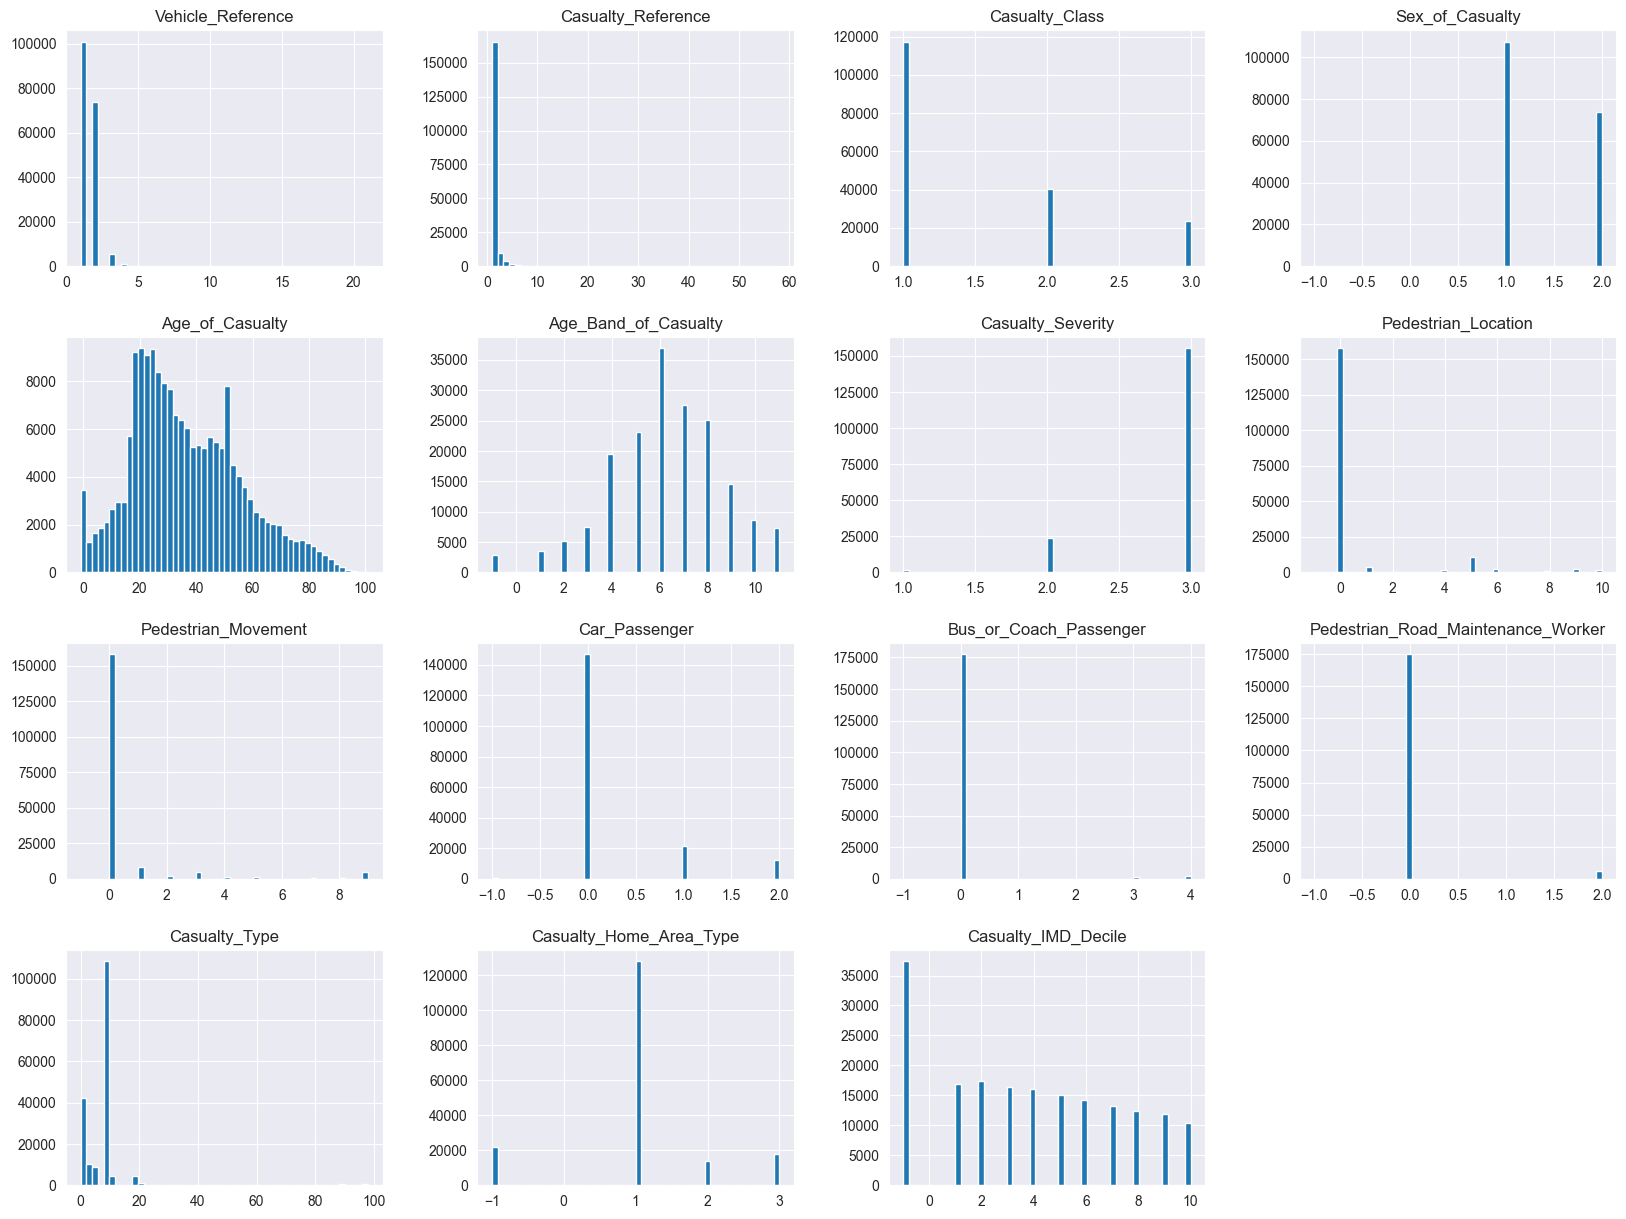

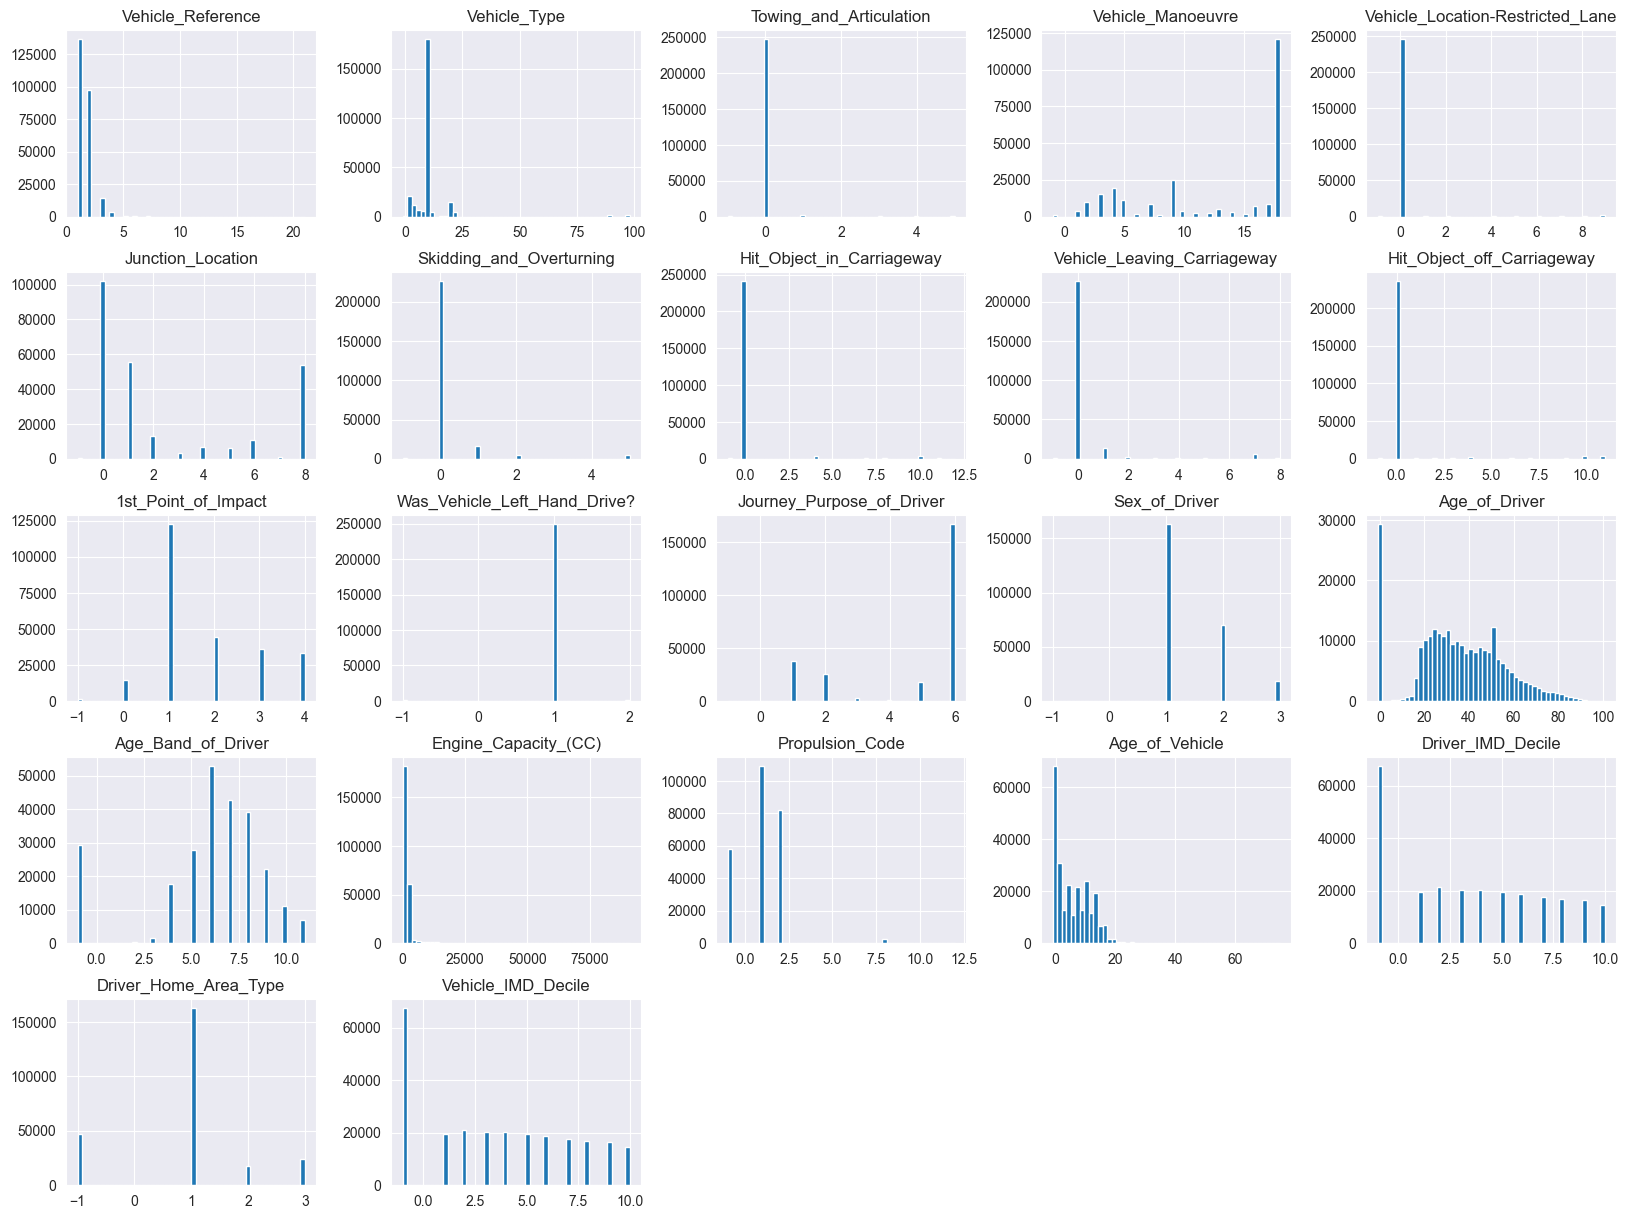

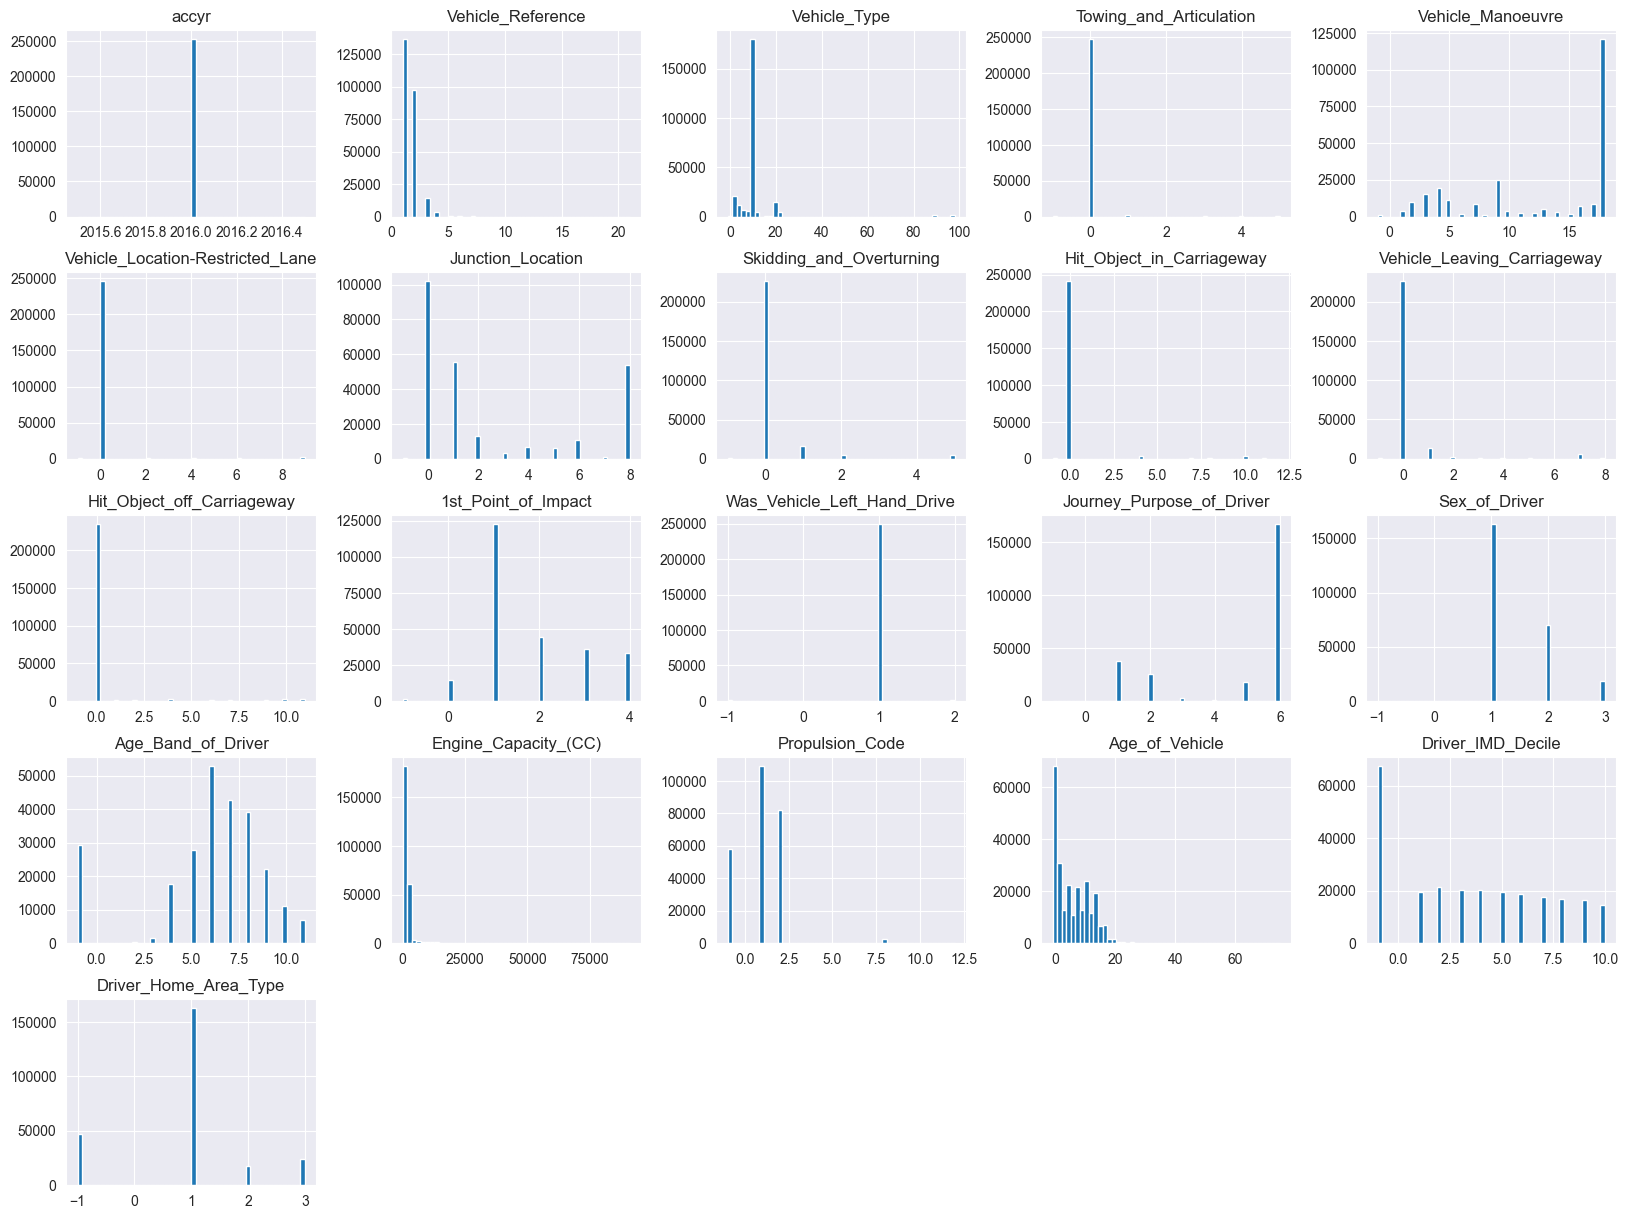

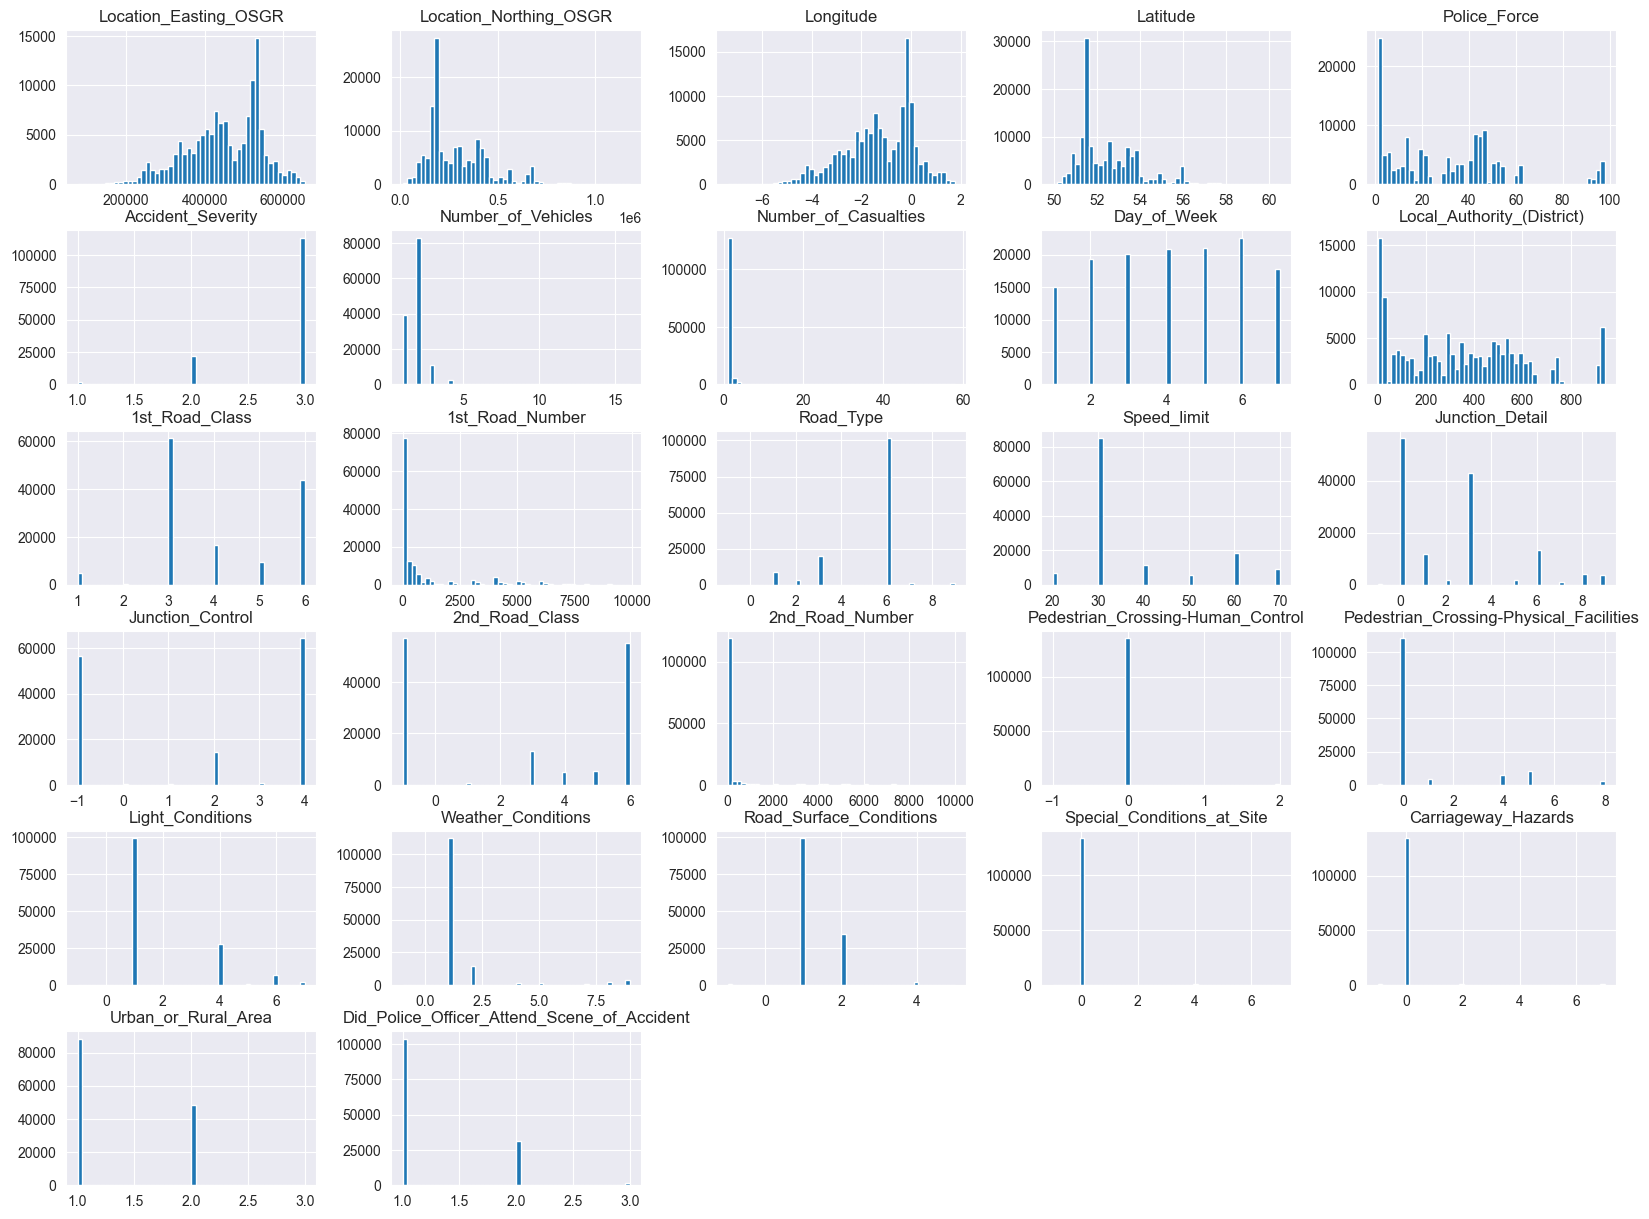

In [8]:
Casualties.hist(bins=50, figsize=(20,15))
Vehicles.hist(bins=50, figsize=(20,15))
MakeModel.hist(bins=50, figsize=(20,15))
Accidents.hist(bins=50, figsize=(20,15))

### Wykresy typu Boxplot

<Axes: >

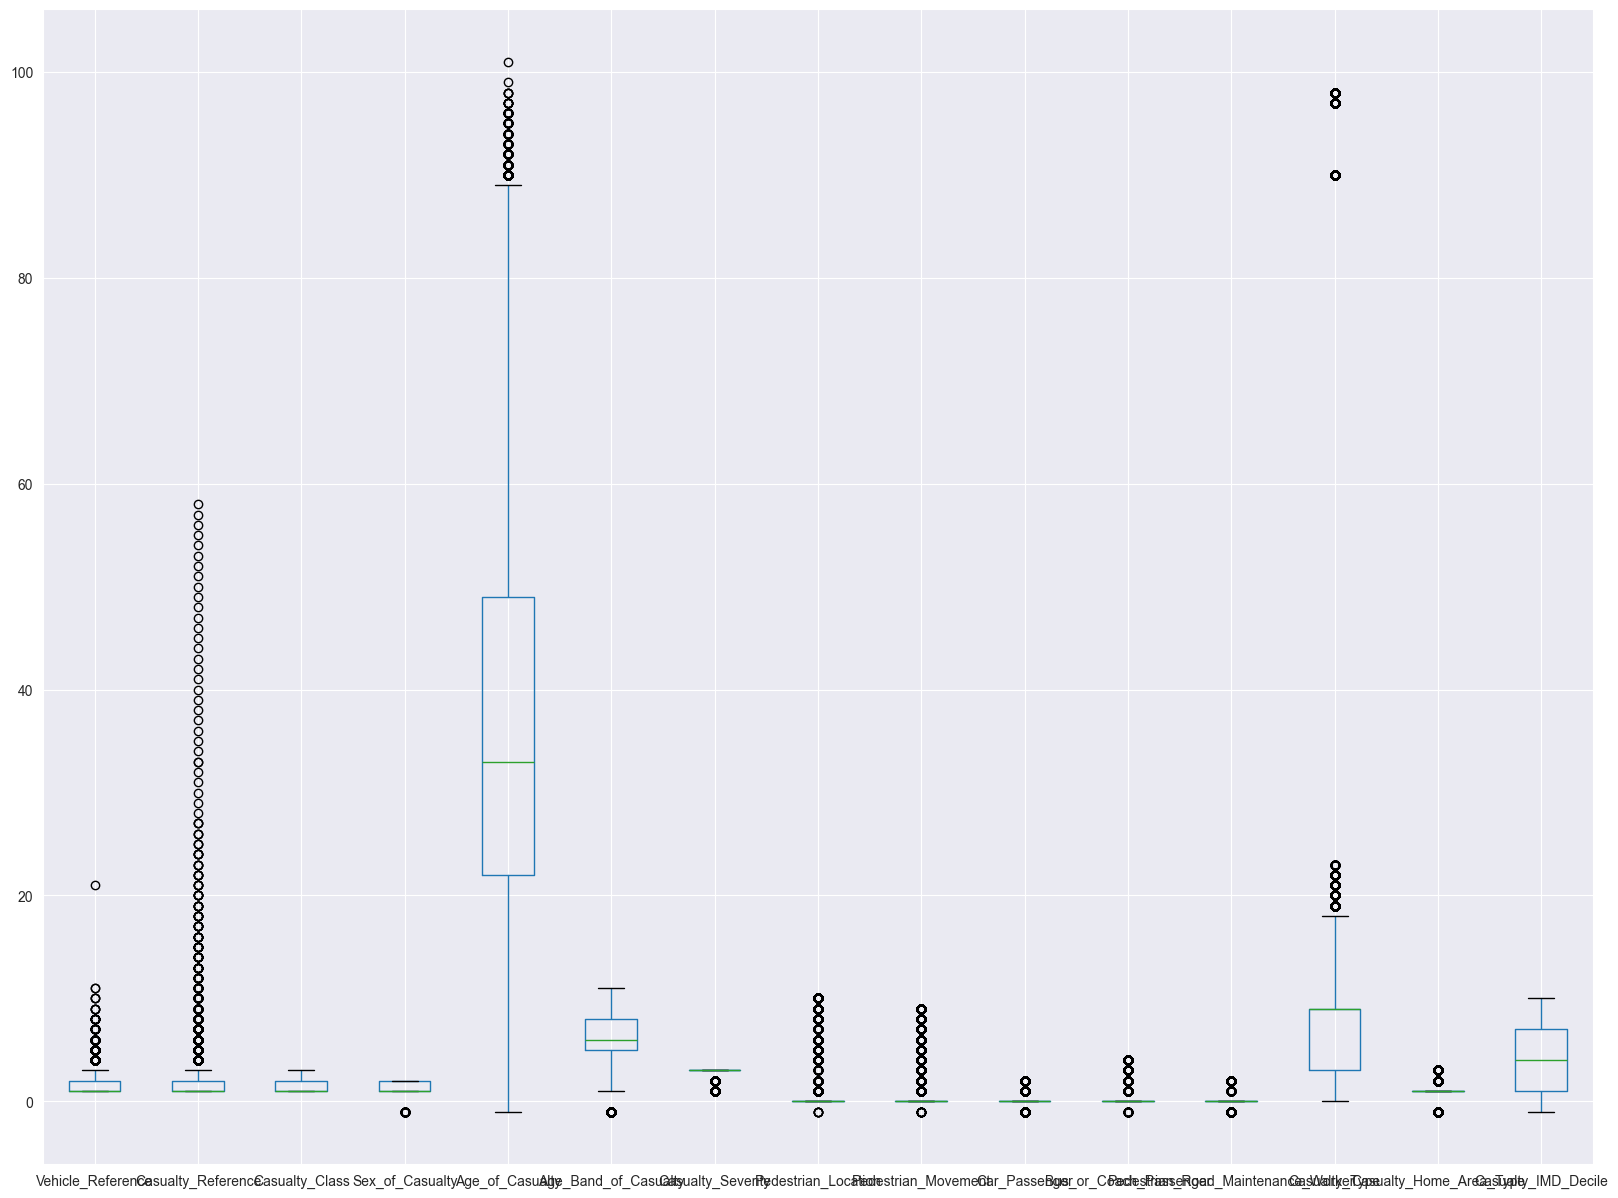

In [9]:
Casualties.boxplot(figsize=(20,15))

<Axes: >

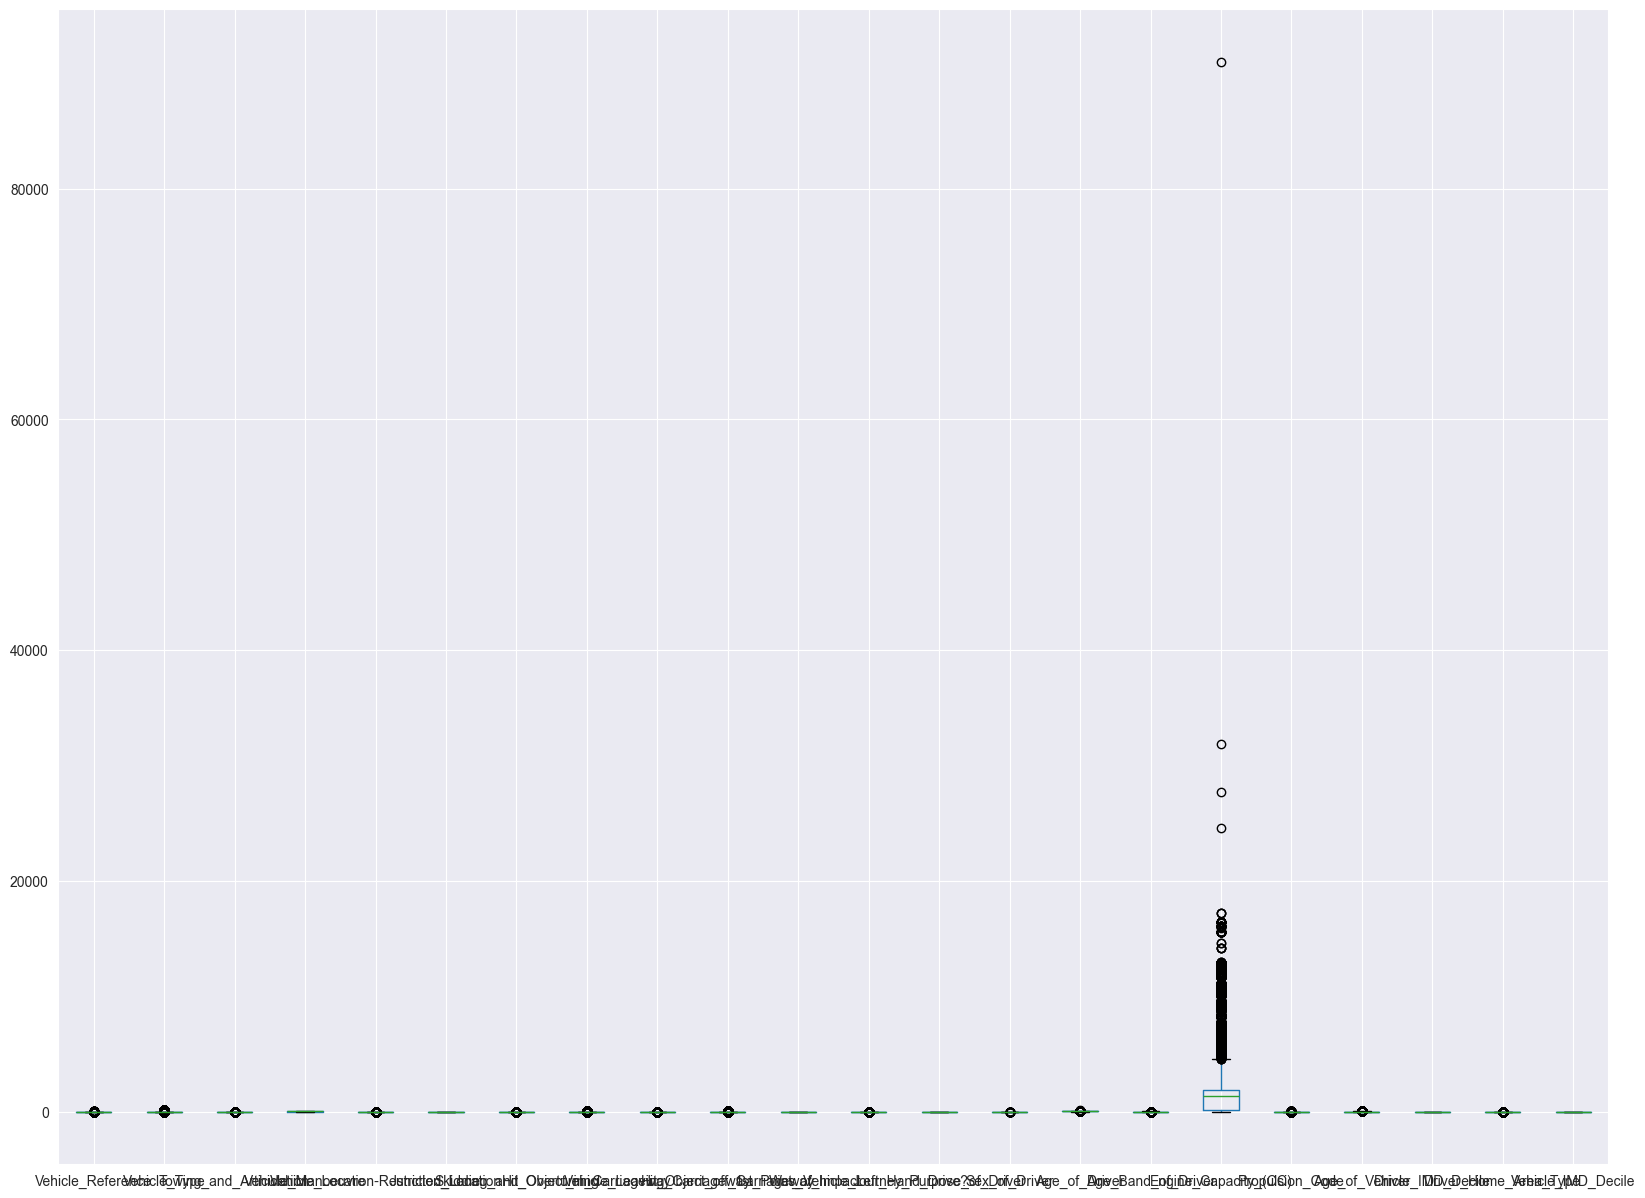

In [10]:
Vehicles.boxplot(figsize=(20,15))

<Axes: >

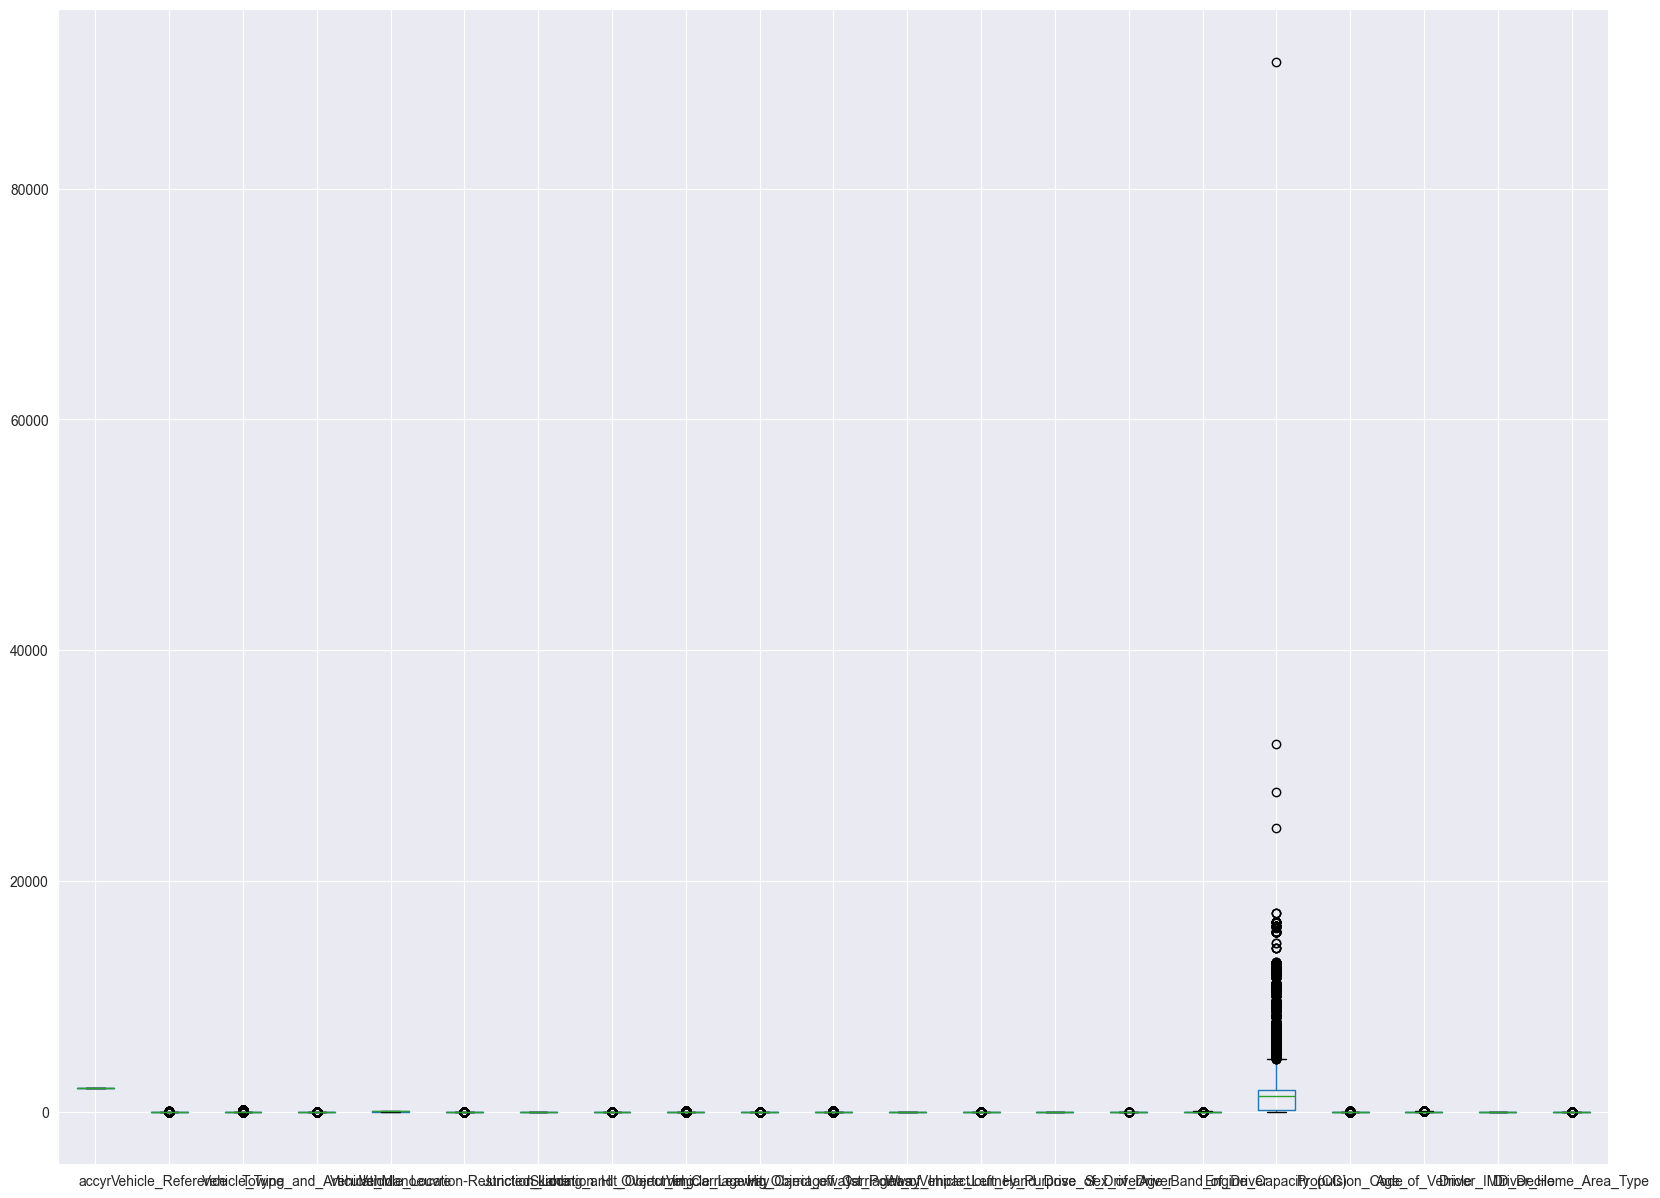

In [11]:
MakeModel.boxplot(figsize=(20,15))

<Axes: >

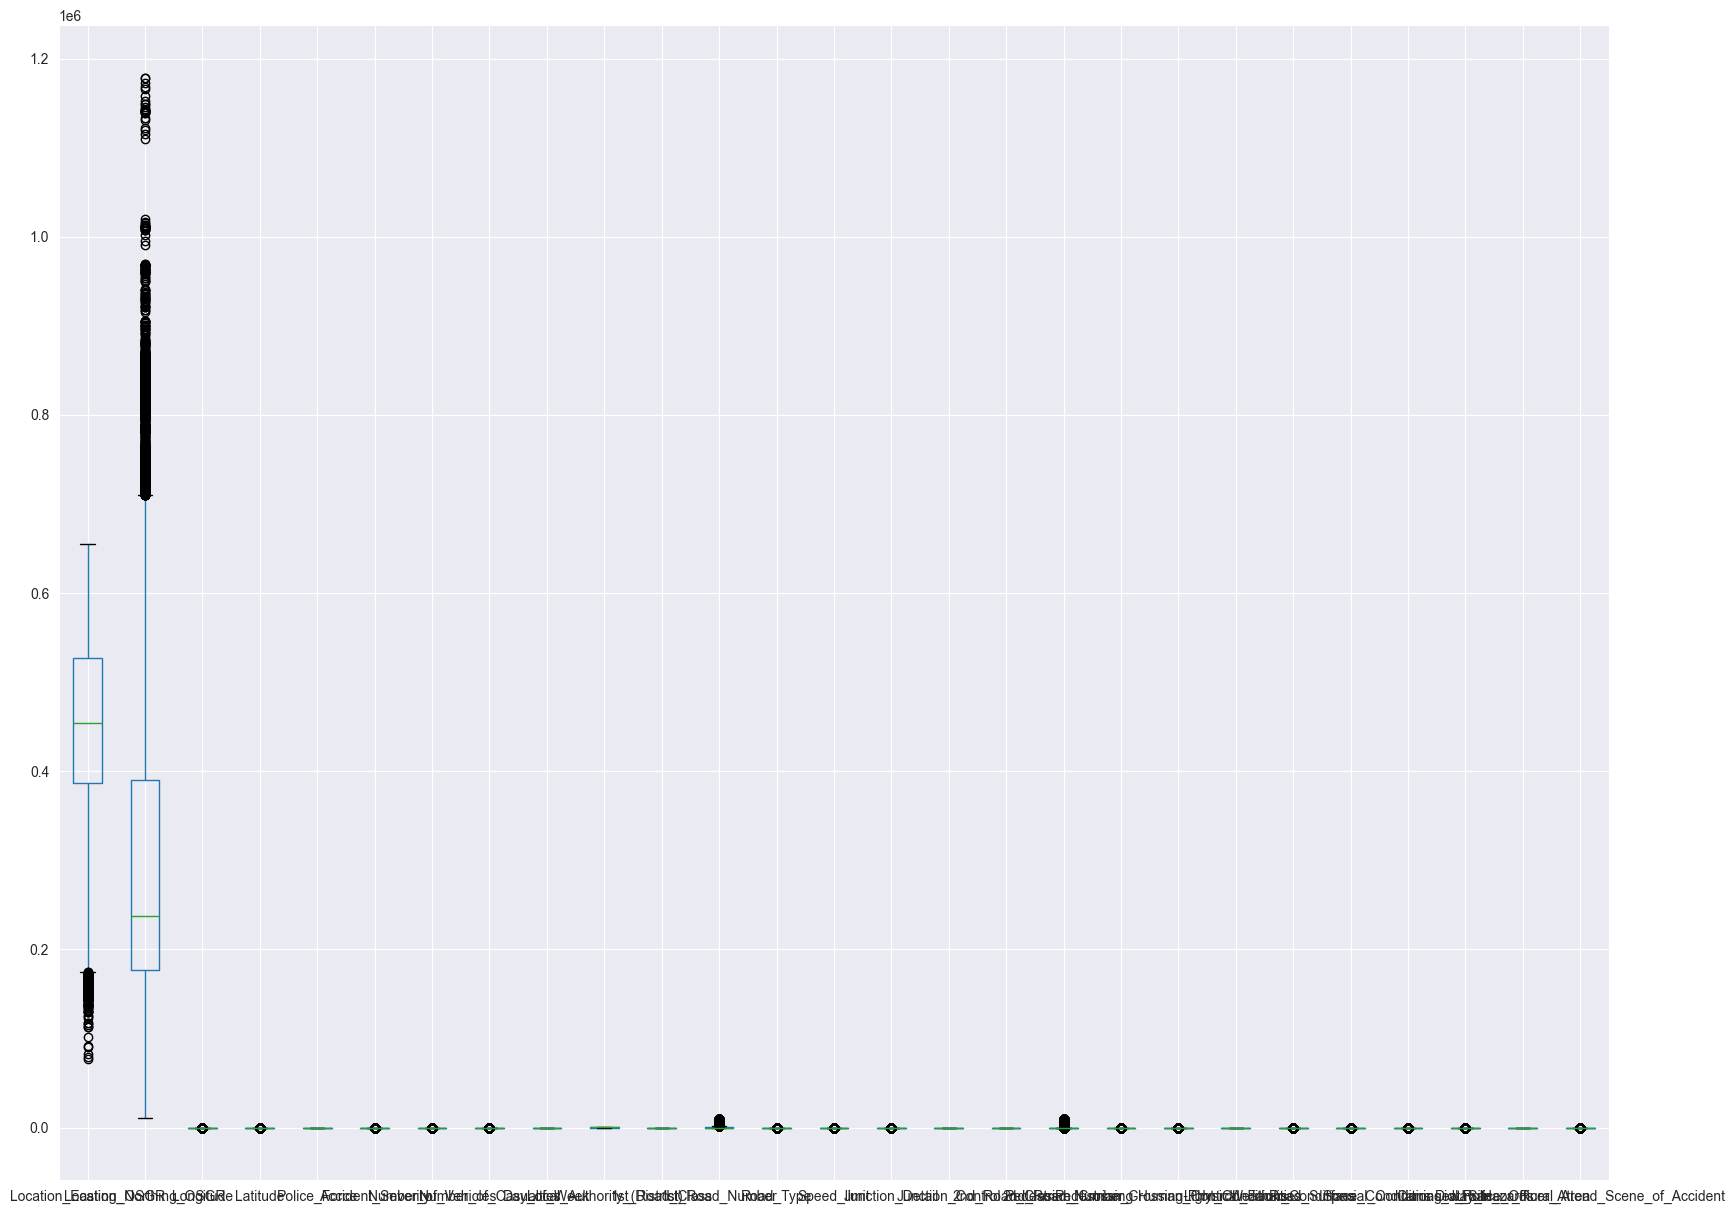

In [12]:
Accidents.boxplot(figsize=(20,15))

### Wykresy dotyczące groźności wypadków

<Axes: xlabel='Accident_Severity', ylabel='Number_of_Casualties'>

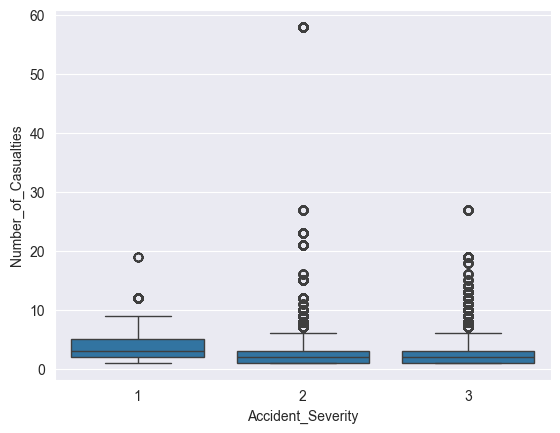

In [18]:
sns.boxplot(x='Accident_Severity', y='Number_of_Casualties', data=Comp_data)

<Axes: xlabel='Accident_Severity', ylabel='count'>

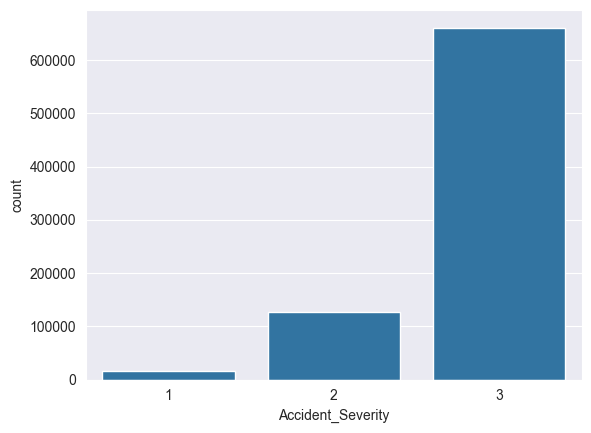

In [19]:
countplt = sns.countplot(x='Accident_Severity', data=Comp_data)
countplt

### Wyodrębnienie kolumny dotyczącej powodu podróży kierowcy

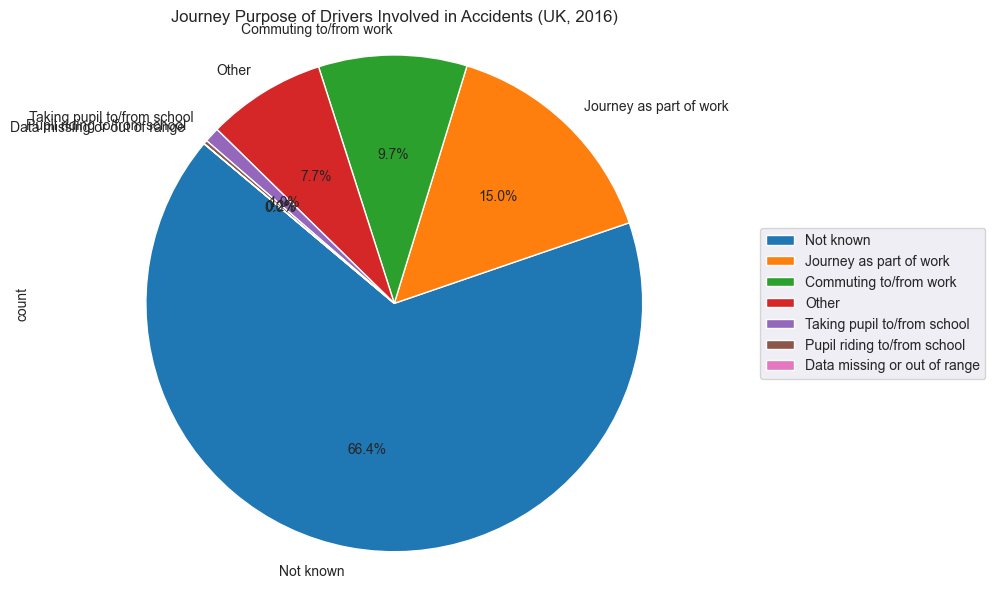

In [23]:
journey_purpose_counts = Comp_data['Journey_Purpose_of_Driver_y'].value_counts()

# Tworzenie opisów do legendy
journey_purpose_legend = {
    1: 'Journey as part of work',
    2: 'Commuting to/from work',
    3: 'Taking pupil to/from school',
    4: 'Pupil riding to/from school',
    5: 'Other',
    6: 'Not known',
    -1: 'Data missing or out of range'
}

# Podstawienie opisów do wartości
journey_purpose_counts.index = journey_purpose_counts.index.map(journey_purpose_legend)

# Tworzenie wykresu kołowego
plt.figure(figsize=(10, 6))
journey_purpose_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Journey Purpose of Drivers Involved in Accidents (UK, 2016)')
plt.axis('equal')  # Ustawienie równych proporcji dla osi x i y



# Przeniesienie legendy poza wykres
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Dostosowanie układu w celu uniknięcia nakładania się elementów
plt.show()

### Mapa wypadków drogowych w Wielkiej Brytanii

In [ ]:
# Utworzenie wykresu mapy
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-8, 2, 49.5, 60], crs=ccrs.PlateCarree())  # Ustawienie granic na Wielką Brytanię

# Dodanie warstwy granic kraju na różowo
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=1.5, edgecolor='pink')

ax.stock_img()

# Dodanie punktów reprezentujących wypadki drogowe
ax.scatter(Comp_data['Longitude'], Comp_data['Latitude'], transform=ccrs.PlateCarree(), color='red', alpha=0.5, s=10)

plt.title('Mapa wypadków drogowych w Wielkiej Brytanii')
plt.show()

### Wykres wypadków drogowych według marek samochodów

Liczba wypadków według marki auta:
make
FORD          98314
VAUXHALL      84486
VOLKSWAGEN    56184
PEUGEOT       34171
BMW           33523
              ...  
JINLIN            1
BENFORD           1
SCORPA            1
Tomos             1
PONTIAC           1
Name: Accident_Index, Length: 383, dtype: int64


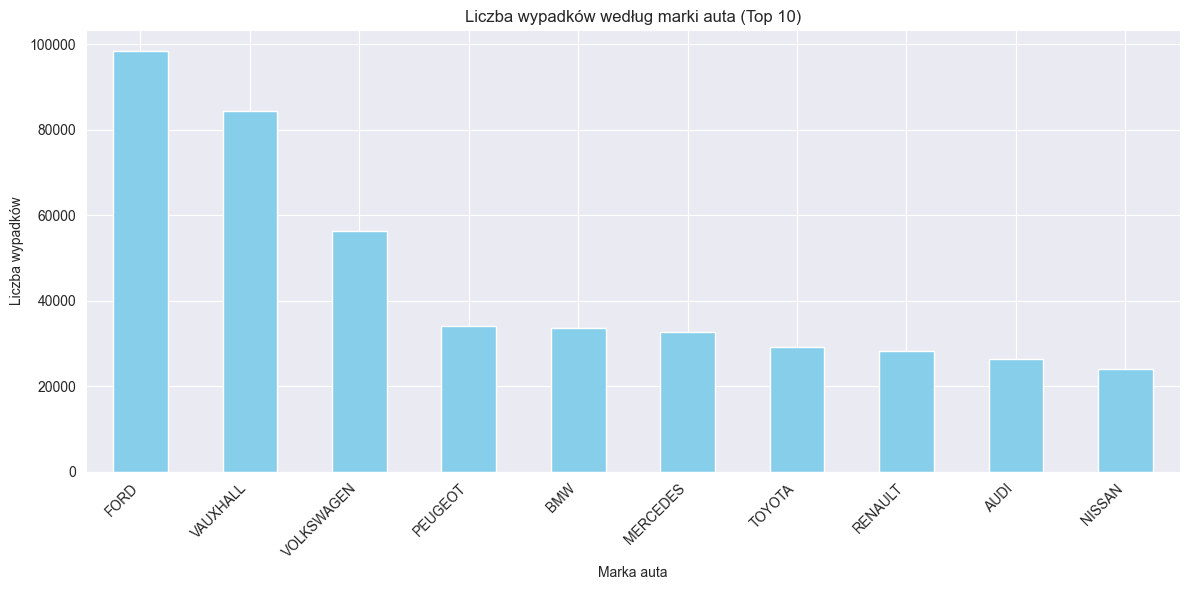

In [24]:
# Analiza liczby wypadków według marki pojazdu
wypadki_marka_auta = Comp_data.groupby('make')['Accident_Index'].count().sort_values(ascending=False)

# Wyświetlenie wyników
print("Liczba wypadków według marki auta:")
print(wypadki_marka_auta)

# Tworzenie wykresu słupkowego
plt.figure(figsize=(12, 6))
wypadki_marka_auta.head(10).plot(kind='bar', color='skyblue')
plt.title('Liczba wypadków według marki auta (Top 10)')
plt.xlabel('Marka auta')
plt.ylabel('Liczba wypadków')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Wykres kołowy wypadków drogowych według płci 

Liczba wypadków według płci:
Sex_of_Driver_y
Brak danych       114
Mężczyzna      520793
Kobieta        231473
Nieznana        52473
Name: Accident_Index, dtype: int64


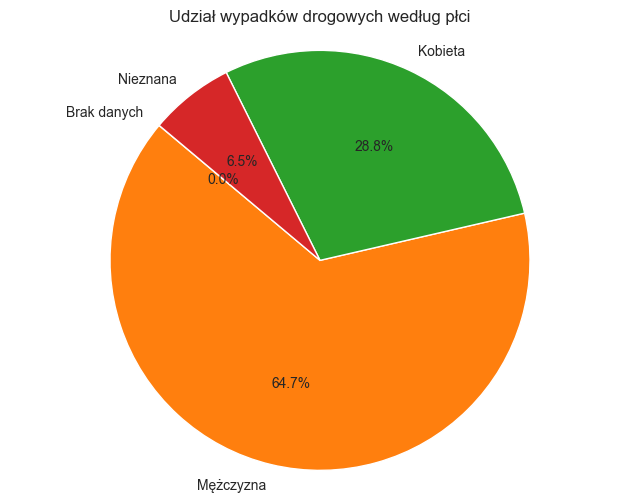

In [39]:
# Tworzenie opisów do legendy
wypadki_plec_legend = {
    1: 'Mężczyzna',
    2: 'Kobieta',
    3: 'Nieznana',
    -1: 'Brak danych'
}

# Analiza wypadków według płci
wypadki_wedlug_plci = Comp_data.groupby('Sex_of_Driver_y')['Accident_Index'].count()

# Podstawienie opisów do wartości
wypadki_wedlug_plci.index = wypadki_wedlug_plci.index.map(wypadki_plec_legend)

# Wyświetlenie wyników
print("Liczba wypadków według płci:")
print(wypadki_wedlug_plci)

# Wykres kołowy przedstawiający udział wypadków według płci
plt.figure(figsize=(8, 6))
plt.pie(wypadki_wedlug_plci, labels=wypadki_wedlug_plci.index, autopct='%1.1f%%', startangle=140)
plt.title('Udział wypadków drogowych według płci')
plt.axis('equal')  # Zapewnia, że koło będzie wyglądać jak koło, a nie jak owal
plt.show()

### Wykres słupkowy wypadków drogowych według wieku kierowców

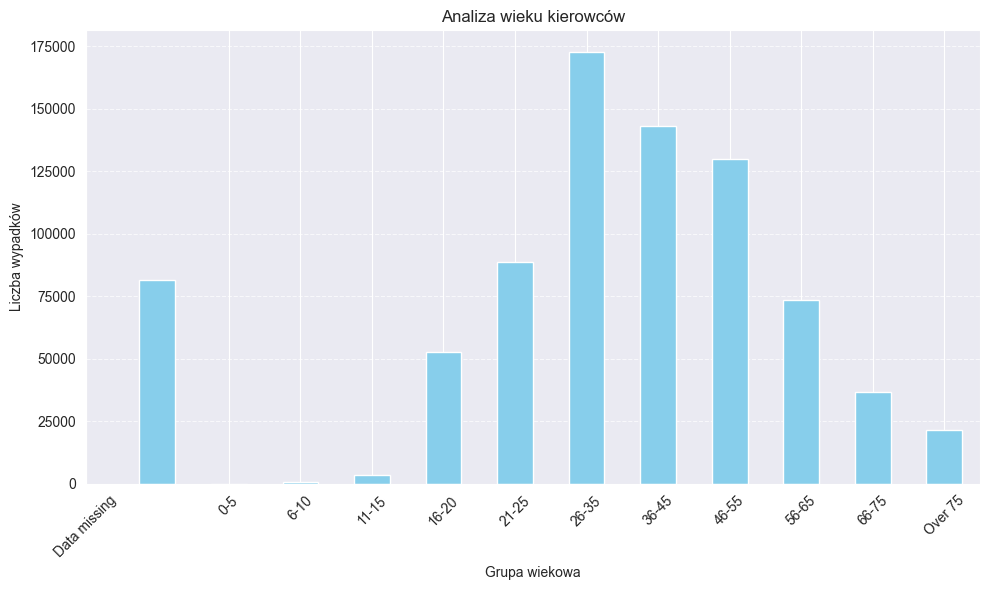

In [40]:
# Analiza wieku kierowców
analiza_wieku = Comp_data['Age_Band_of_Driver_y'].value_counts().sort_index()

etykiety = {
    '1': '0-5',
    '2': '6-10',
    '3': '11-15',
    '4': '16-20',
    '5': '21-25',
    '6': '26-35',
    '7': '36-45',
    '8': '46-55',
    '9': '56-65',
    '10': '66-75',
    '11': 'Over 75',
    '-1': 'Data missing'
}


# Tworzenie wykresu słupkowego z etykietami
plt.figure(figsize=(10, 6))
analiza_wieku.plot(kind='bar', color='skyblue')
plt.title('Analiza wieku kierowców')
plt.xlabel('Grupa wiekowa')
plt.ylabel('Liczba wypadków')
plt.xticks(rotation=45)
plt.xticks(analiza_wieku.index, [etykiety.get(str(x), 'Unknown') for x in analiza_wieku.index])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Pairplot z wybranymi danymi

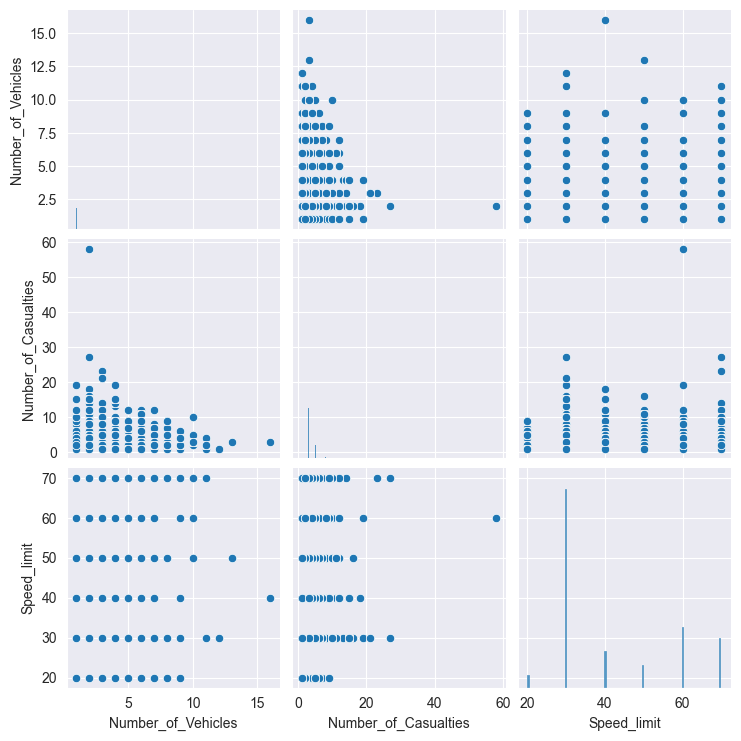

In [26]:
data_to_plot = Comp_data[['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']]

# Przeprowadzenie analizy pairplotów
sns.pairplot(data_to_plot)
plt.show()